In [62]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [88]:
rawplot_folder = '../reports/raw_plot/'

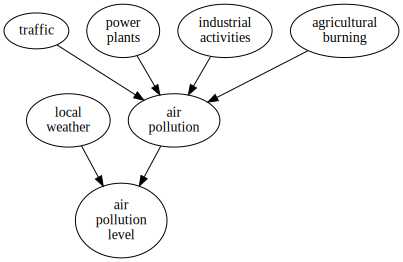

In [10]:
pollution = CausalGraphicalModel(
    nodes=["agricultural\nburning", "traffic", "power\nplants", "industrial\nactivities", "local\nweather", "air\npollution", "air\npollution\nlevel"],
    edges=[
        ("agricultural\nburning", "air\npollution"), 
        ("traffic", "air\npollution"), 
        ("power\nplants", "air\npollution"),
        ("industrial\nactivities", "air\npollution"), 
        ("air\npollution", "air\npollution\nlevel"),
        ("local\nweather", "air\npollution\nlevel")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
pollution.draw()

# Visualize During ML training

In [6]:
data = Dataset('Chiang Mai')
# load raw data 
data.load_()
# build the first dataset 
data.feature_no_fire()
# use default fire feature
data.merge_fire()
data.pollutant = 'PM2.5'

data no fire has shape (78565, 14)
use default fire feature


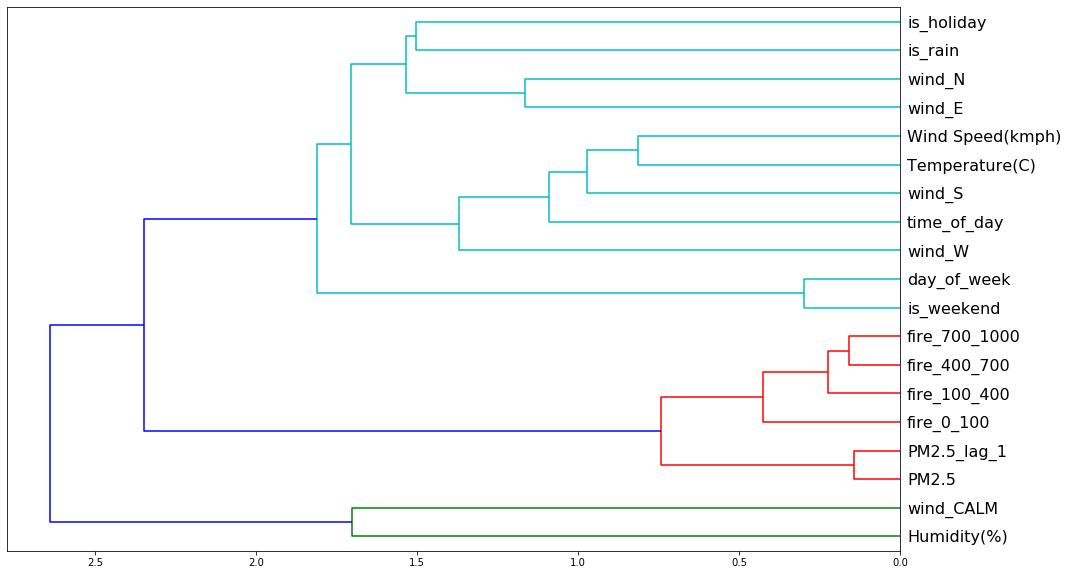

In [7]:
# plot dendogram
plot_dendogram(data=data.data)

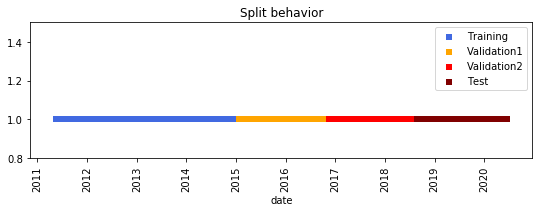

In [8]:
# visualize the split 
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
display_time_split(data.split_list)

# Data Exploration Visualization

In [4]:
def plot_all_pollutions(poll_df, city_name='',filename=None,transition_dict=None, color_labels=None, level_name=None):
    """Plot all pollutant data over time. 
    
    """
    if transition_dict==None:
        transition_dict = { 'PM2.5': [0, 35.5, 55.4, 150.4, 1e3],
                  'PM10': [0, 155, 254, 354, 1e3],
                  'O3':[0, 70 , 85, 105 ,1e3],
                  'SO2':[0, 75, 185, 304,1e3],
                  'NO2': [0, 100, 360, 649,1e3],
                  'CO': [0, 6.4, 12.5, 15.4,1e3]}

    if color_labels==None:
        color_labels = ['green', 'orange', 'red','purple']
    
    if level_name==None:
        level_names = ['satisfactory', 'moderate', 'unhealthy','very unhealthy']
    
    gas_list = poll_df.columns
    len_gas = len(gas_list)
    _, ax = plt.subplots(len_gas, 1, figsize=(10, 3*len_gas),sharex=True)

    for i, _ in enumerate(ax):
        col = gas_list[i]
        poll_data = poll_df[[col]].dropna()
        poll_data['color'] = pd.cut(poll_data[col], bins=transition_dict[col], labels=color_labels)

        for color, legend in zip(color_labels, level_names):
            temp = poll_data[poll_data['color'] == color]
            # plot the data for each pollution level
            ax[i].scatter(temp.index, temp[col],
                  c=temp['color'], marker='.', label=legend,alpha=0.7)
        
            if col in ['PM10','PM2.5']:
                ax[i].set_ylabel(col + '($\mu g/m^3$)')
            elif col in ['O3','NO2','SO2']:
                ax[i].set_ylabel(col + '(ppb)')
            elif col == 'CO':
                ax[i].set_ylabel(col + '(ppm)')
        
            ax[i].axhline(transition_dict[col][1],color='orange')
            if i in [0,1,2]:
                ax[i].axhline(transition_dict[col][2],color='red')
            if i in [0,1,2]:
                ax[i].axhline(transition_dict[col][3],color='purple')
    
    ax[0].legend(loc='upper left')
    ax[0].set_xlim([poll_df.index.min(), poll_df.index.max()])
    ax[0].set_title(f'Pollutants Data for {city_name} Averaged from All Staions')
    ax[-1].set_xlabel('date')

    plt.tight_layout()

In [9]:
poll_df = data.poll_df
city_name = data.city_name

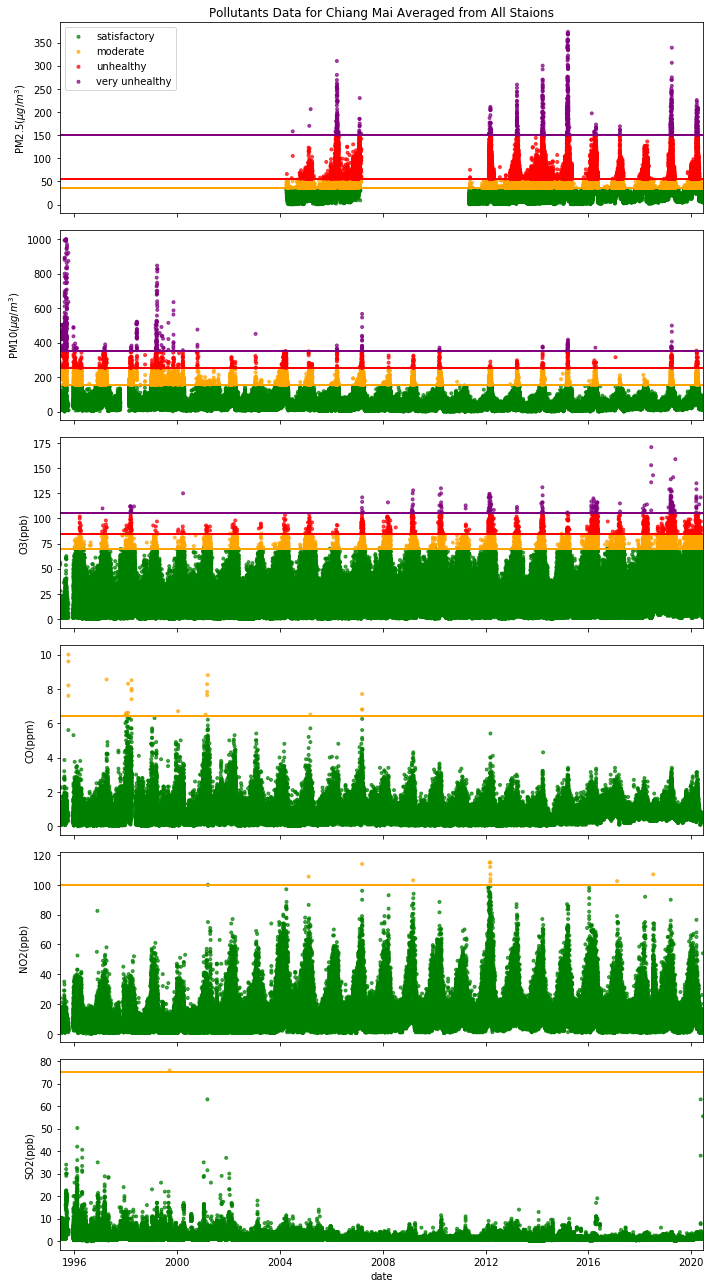

In [17]:
plot_all_pollutions(poll_df, city_name=city_name)

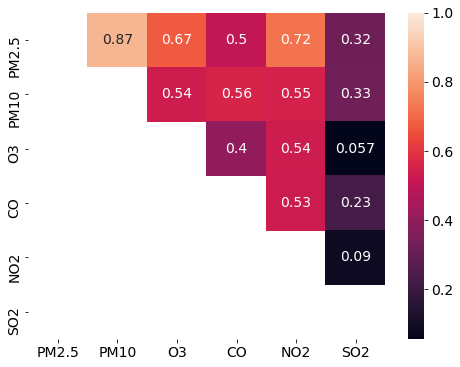

In [158]:
plot_corr(data.poll_df.resample('d').mean())

aqi 100 in  12-13 to 05-11
aqi 150 in  02-21 to 04-21


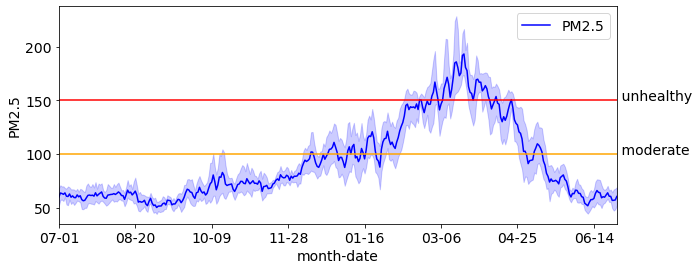

In [30]:
plot_season_aqi(data.poll_df.copy(), data.roll_dict, 'PM2.5', filename=data.report_folder + 'seasonal_pattern_PM25.png')

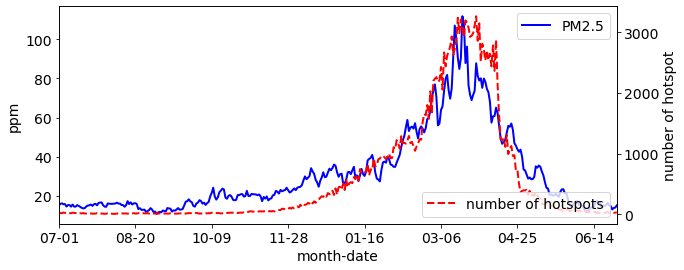

In [58]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
#poll_aqi = poll_to_aqi(data.poll_df.copy(), data.roll_dict)
winter_day_dict, mean_day = plot_season_avg(data.poll_df.copy(), 'PM2.5', ax, plot_error=False, roll=True, agg='mean',linewidth=2 )

ax.set_ylabel('ppm')
ax1 = ax.twinx()
fire_hour = data.fire[['count']].resample('d').sum()
fire_hour.columns = ['number of hotspots']
winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.copy(), 'number of hotspots', ax1, plot_error=False, roll=False, agg='mean',color='red',linestyle='dashed',linewidth=2)

ax1.legend(loc='lower right')
ax1.set_ylabel('number of hotspot')
plt.savefig(data.report_folder + 'fire_PM25_season.png')

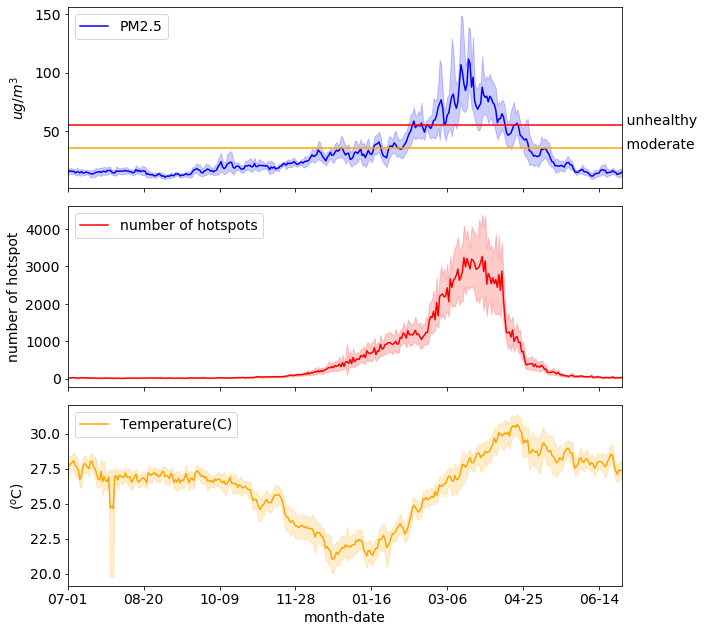

In [21]:
# traffic and time of day
_, ax = plt.subplots(3,1, figsize=(10,9),sharex=True)
#poll_aqi = poll_to_aqi(data.poll_df.copy(), data.roll_dict)
winter_day_dict, mean_day = plot_season_avg(data.poll_df.copy(), 'PM2.5', ax[0], plot_error=True, roll=True, agg='mean',linewidth=2 )

ax[0].set_ylabel('$ug/m^3$')

 
# aqiline 
ax[0].axhline(35.4, color='orange')
ax[0].axhline(55.4, color='red')
ax[0].text(365, 35.5, ' moderate',  horizontalalignment='left')
ax[0].text(365, 55.4, ' unhealthy',  horizontalalignment='left')


fire_hour = data.fire[['count']].resample('d').sum()
fire_hour.columns = ['number of hotspots']
winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.copy(), 'number of hotspots', ax[1], plot_error=True, roll=False, agg='mean',color='red',linestyle='solid',linewidth=2)
ax[1].set_ylabel('number of hotspot')


t_hour = data.wea[['Temperature(C)', 'Wind Speed(kmph)']].resample('d').mean()

winter_day_dict, temperature = plot_season_avg(t_hour.copy(), 'Temperature(C)', ax[2], plot_error=True, roll=False, agg='mean',color='orange',linestyle='solid',linewidth=2)
ax[2].set_ylabel('($^o$C)')

#a = ax[2].twinx()
#winter_day_dict, temperature = plot_season_avg(t_hour.copy(), 'Wind Speed(kmph)', a, plot_error=True, roll=False, agg='mean',color='green',linestyle='solid',linewidth=2)
#a.set_ylabel('km/h')


for a in ax:
    a.legend(loc='upper left')
plt.tight_layout()
plt.savefig(data.report_folder + 'fire_PM25_season.png')

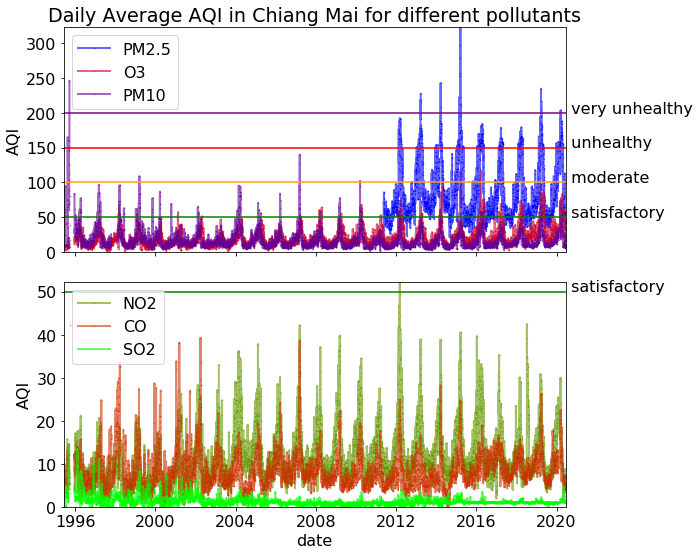

In [7]:
plot_polls_aqi(data.poll_df.copy(), data.roll_dict, data.city_name, filename=data.report_folder + 'all_pol_aqi.png' )

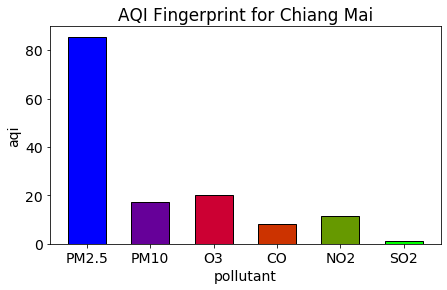

In [16]:
plot_chem_print(poll_to_aqi(data.poll_df.copy(), data.roll_dict).mean(axis=0), data.city_name, filename=data.report_folder + 'fingerprint.png')

In [27]:
year_fire = cal_sea_yr(data.fire.resample('d').sum()[['count']].copy(), agg='mean')
year_fire.columns = ['number of hotspots']
year_poll = cal_sea_yr(data.poll_df.resample('d').mean().copy())
year_temp = cal_sea_yr(data.wea[['Temperature(C)']].resample('d').mean().copy())

# keep only the data with finite fire columns
year_avg = pd.concat([ year_poll.loc[year_fire.index], year_fire, year_temp.loc[year_fire.index]],axis=1)[[ 'PM2.5', 'PM10','number of hotspots', 'Temperature(C)']]
year_avg.corr('spearman')

,PM2.5,PM10,number of hotspots,Temperature(C)
PM2.5,1.000000,0.850000,0.400000,-0.016667
PM10,0.850000,1.000000,0.760578,0.215686
number of hotspots,0.400000,0.760578,1.000000,-0.077399
Temperature(C),-0.016667,0.215686,-0.077399,1.000000


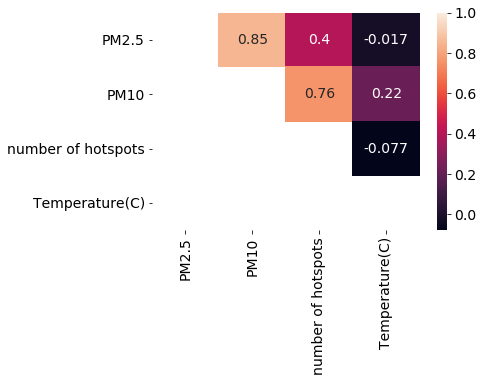

In [156]:
plot_corr(year_avg, figsize=(6,4))

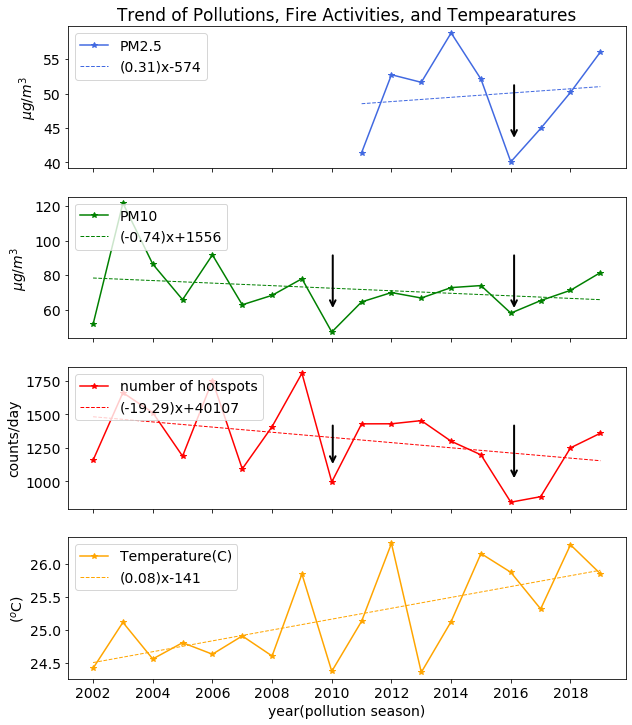

In [68]:
ax, year_avg = plot_yearly_ln(data)

for i, a in enumerate(ax):
    if i != 3:
        a.annotate('', xy=(0.8, 0.2),xytext=(0.8, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))

ax[1].annotate('', xy=(0.475, 0.2),xytext=(0.475, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))
ax[2].annotate('', xy=(0.475, 0.3),xytext=(0.475, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))

plt.savefig(data.report_folder + 'compare_ln_trends.png')

# Analyze Fire activities

In [87]:
city_info = {'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}
# data to plot in excel
plot_data_list = []
x = merc_x(city_info['Longitude'])
y = merc_y(city_info['Latitude'])
stepx = 2E5
stepy = stepx

stepx = 800E3
stepy = stepx

# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-0.9*stepx,x+1.1*stepx), y_range=(y-stepy*0.5, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Fire Zone')

p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))


p.circle(x,y,color='black',line_color='black',size=5, legend_label='Chiang Mai')

i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
print(month)
color = 'red'
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')
plot_data_list.append(data)


month_list = ['2018-12','2019-01']
month = month_list[i]
print(month)
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')
plot_data_list.append(data)


labels = ['0-100km','100-200km', '200-400km','400-700km','700-1000km']
labels.reverse()
rs = [120, 200, 400 , 700 , 1000]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    plot_data_list.append(pd.DataFrame(xy.transpose(),columns=['x','y']))
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)

show(p)

2019-03
2018-12


In [90]:
# explore raw plot
h_filename = rawplot_folder +'fire_zone'
for i, df in enumerate(plot_data_list):
    df.to_csv(h_filename + f'{i}.csv', index=False)

In [38]:
# loading world map
gdf =  gpd.read_file('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/world_maps/map3/')
country_list = ['Thailand', 'China', 'Vietnam', 'Myanmar (Burma)','Cambodia', 'Laos' ]
gdf.columns = ['OBJECTID', 'NAME', 'geometry']
gdf = gdf[gdf['NAME'].isin(country_list)].reset_index(drop=True)
gdf['NAME'] = ['Myanmar', 'Cambodia', 'China', 'Laos', 'Thailand', 'Vietnam']
gdf = gdf.sort_values('NAME')

# create a 1000 km polygon in mercator in meter
circle_gons = get_circle(x_cen=x, y_cen=y, r=1000*1000, num_data=1E4)
# convert into a tuple 
circle_gons = {'geometry': Polygon(list(map(tuple, circle_gons.transpose())))}

circle_gons = gpd.GeoDataFrame(circle_gons, crs="EPSG:3395",index=[0])
# convert to 6933
circle_6933 = circle_gons['geometry'].to_crs(epsg=6933)
circle_6933 = circle_6933.values[0] 

# calculate the area within 1000 km radius 
temp = gdf.copy()
# convert to mercator
temp['geometry'] = gdf['geometry'].to_crs(epsg=6933)
inter_area = []
for (i, row) in temp.iterrows():
    polygon1 = row['geometry'].intersection(circle_6933) 
    inter_area.append(int(polygon1.area/10**6))
    p = gpd.GeoSeries(polygon1)

gdf['inter_area(km2)'] = inter_area


# load fire data 
dataset = Dataset('Chiang Mai')
# load raw data 
dataset.load_()
fire = dataset.fire.copy()

In [41]:
# obtain the seasonal pattern of fire by country 
fire_country = pd.pivot_table(fire, values='count', columns='country',index=fire.index,aggfunc='sum').fillna(0).astype(int)
fire_country = fire_country.resample('d').sum()
fire_country_sea, winter_day_dict = season_avg(fire_country, cols=fire_country.columns.to_list(), roll=False, agg='sum', offset=182)
fire_country_sea = fire_country_sea.groupby('winter_day').mean()[fire_country.columns]

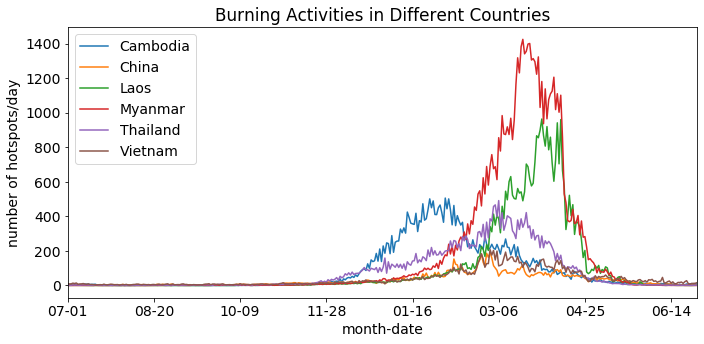

In [52]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(dataset.report_folder + 'hotspots_country.png')

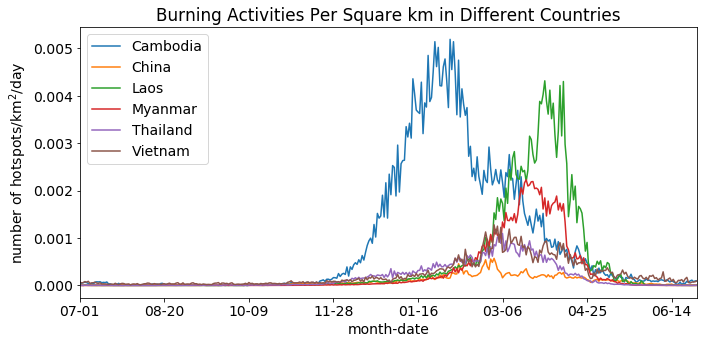

In [51]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea/gdf['inter_area(km2)'].values)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities Per Square km in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/km$^2$/day')
plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_per_km2.png')

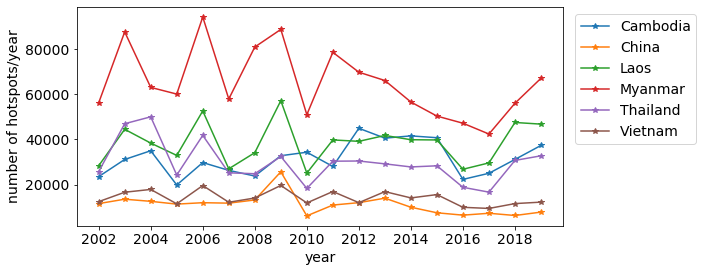

In [57]:
fire_country_year = add_season(fire_country).drop('season',axis=1)

_, ax = plt.subplots(1,1, figsize=(10,4))
fire_country_year.groupby('year').sum().drop(2020).plot(marker='*',ax=ax)
ax.set_ylabel('number of hotspots/year')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_country.png')

In [46]:
# observing a repeating patterns 
fire = dataset.fire.copy()

fire = fire.reset_index()
# add coordinate tuple
factor = 1
fire['coor'] = [(x, y) for x, y in zip(((fire['long_km']/factor).round() *
                                        factor).astype(int), ((fire['lat_km']/factor).round()*factor).astype(int))]
# drop hotspot outside the countrires considered
fire = fire.dropna()
# round the datetime information to day
fire['datetime'] = fire['datetime'].dt.round('d')
country_list = fire['country'].unique()

In [60]:
# repeating hotspots with between year
repeat_out_year_accum = []
repeat_list = [2]
for country in country_list:
    s = cal_repeat_spots(fire[fire['country']==country].set_index('datetime').copy(),repeat_list=repeat_list,accum=True,group_list=['lat_km','long_km'])
    s.name = country 
    repeat_out_year_accum.append(s)
    
repeat_out_year_accum =   pd.concat(repeat_out_year_accum,axis=1)

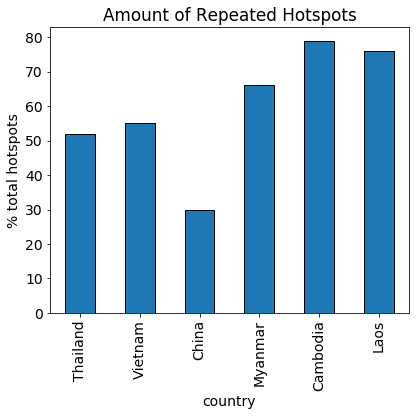

In [61]:
_, ax = plt.subplots(1,1,figsize=(6,6))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year_accum.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = 'Amount of Repeated Hotspots'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')
    
plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_repeat.png')